In [6021]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6022]:
train_df = pd.read_csv('./data/churn_train_xg.csv')
test_df = pd.read_csv('./data/churn_test_xg.csv')

# ● Analysera datan

In [6023]:
train_df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6024]:
train_df.duplicated().sum()

0

In [6025]:
train_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5634.000000,5634.000000,5634.000000
mean,0.162052,32.651757,64.828852
std,0.368531,24.568438,30.187464
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.462500
50%,0.000000,29.000000,70.400000
75%,0.000000,56.000000,90.050000
max,1.000000,72.000000,118.750000


In [6026]:
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


## ○ Hur ser fördelningen av target datan ut? Är den jämnt fördelad? Om inte, kan det ställa till med problem?


Customers who stayed:   4148
Customers who churned:   1486


<Axes: >

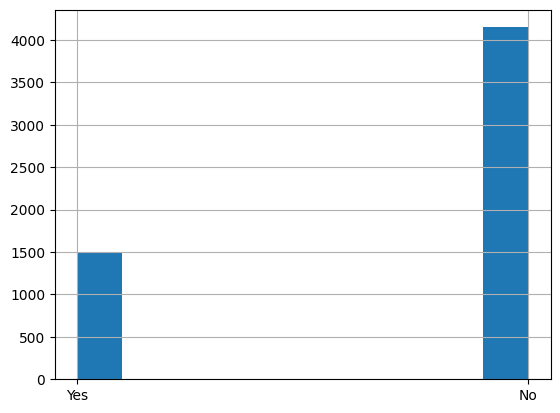

In [6027]:
target_dist = train_df['Churn'].value_counts()
print('Customers who stayed:  ', target_dist[0])
print('Customers who churned:  ', target_dist[1])

train_df['Churn'].hist()

In [6028]:
print(f'Percent who stayed: {round(target_dist[0]/sum(target_dist), ndigits=2)*100}%')
print(f'Percent who churned: {round(target_dist[1]/sum(target_dist), ndigits=2)*100}%')

Percent who stayed: 74.0%
Percent who churned: 26.0%


### Vi kan se väldigt klart och tydligt att det är stor skillnad på vår target data. Detta kan orsaka att modellen predictar targeten som har majoritet.
### Det vi kan göra åt detta är t.ex:
#### ● Upsampla minoritets klassen, med en teknik som kallas SMOTE så skapar den upp ny data som liknar minoritets klassen.
#### ● Undersampla majoritets klassen, då tar man bort data från majoritets klassen, detta är inte bra att göra när man har små dataset
#### ● Ändra class weights parametern i XGboost modellen så att minoritets klassen har mer betydelse på prediktionen.

### Jag kommer i första hand försöka ändra bland class weights parametern i modellen, men även pröva ett exempel där jag upsamplar minoritets klassen senare i min analys.

# ● Förbered datan för att kunna användas av modellen
## ○ Finns det data som ej borde användas? Varför i så fall?

### Eftersom att customerID attributet inte spelar någon roll i hurvida en kund lämnar eller ej så kommer jag droppa den.

In [6029]:
train_df = train_df.drop(columns='customerID')
test_df = test_df.drop(columns='customerID')

### Ett annat attribut som jag oftast finner intressant under analyser är gender, jag testar att se om varesig man är en man eller kvinna spelar roll i hurvida sannorlikheten är att man kommer lämna eller inte.

In [6030]:
train_df[train_df['Churn']=='Yes']['gender'].value_counts()

gender
Male      747
Female    739
Name: count, dtype: int64

### Som vi ser ovanför så är sannorlikheten väldigt lika för om man är man eller kvinna om man kommer lämna eller inte, vi skulle kunna göra så att vi droppar även detta attribut då det inte kommer göra någon direkt inverkan på vår modell, men jag väljer att låta den vara kvar.

## ○ Det finns en hel del textdata som måste behandlas på något vis (finns flera olika alternativ).

In [6031]:
train_df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### En observation efter att ha sett att TotalCharges är ett object men i datasetet verkar den innehålla floats precis som MonthlyCharges men att det är totalt vad kunden betalat i avgifter, när jag försökte göra om den till float så får jag error, jag skapar en funktion för att ta fram vad det är för värden och hur många som inte går att konvertera.

In [6032]:
def can_convert(value):
    try:
        float(value)
        return True
    except:
        return False

In [6033]:
train_unconvertable = []
for v in train_df['TotalCharges']:
    if can_convert(v) == False:
        train_unconvertable.append(v)

In [6034]:
test_unconvertable = []
for v in test_df['TotalCharges']:
    if can_convert(v) == False:
        test_unconvertable.append(v)

In [6035]:
print('Unconvertable in train set: ',train_unconvertable)
print('Count: ', len(train_unconvertable))

Unconvertable in train set:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Count:  8


In [6036]:
print('Unconvertable in test set: ',test_unconvertable)
print('Count: ', len(test_unconvertable))

Unconvertable in test set:  [' ', ' ', ' ']
Count:  3


### Nu ser jag att samtliga värden som inte går att konvertera till float är tomma string rader, jag väljer att byta ut dom till 0 eftersom att det ska betyda att kunden inte blivit debiterad någonting ännu, och detta kommer bli bättre för min egna encoder senare. Men eftersom att jag gör så med träningsdatan så behöver jag även göra det med testdatan. Man ska ju inte ändra i testdatan utan låta den vara intakt, men jag känner att detta inte gör någon skillnad då en tom string är samma sak som att den hade varit 0.

In [6037]:
train_df.loc[train_df['TotalCharges'] == ' ', 'TotalCharges'] = 0
test_df.loc[test_df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [6038]:
train_df['TotalCharges'] = train_df['TotalCharges'].astype(float)
test_df['TotalCharges'] = test_df['TotalCharges'].astype(float)

### Efter att ha kollat vilka typer av data som är i datasetet så ser jag att majoriteten är object och sedan finns det två int och efter att jag gjort det tidigare steget så finns även nu två float, min första tanke och det jag vill pröva först är att göra om object till int, men dom andra låter jag vara kvar som dom är, men för att se om detta får ett bättre resultat än att även göra om floaten till int så gör jag en enkel funktion som predictar med dom olika alternativen och ser vilken som får bäst score.

In [6039]:
def check_best_encoder(train_df,test_df, categorical=False):
    x_train = train_df.drop(columns='Churn')
    y_train = train_df['Churn']
    x_test = test_df.drop(columns='Churn')
    y_test = test_df['Churn']
    m_x_train = xgb.DMatrix(data=x_train,label=y_train, enable_categorical=categorical)
    clf = xgb.train(
        params={
            'objective':'multi:softmax',
            'num_class':2,
        },
        dtrain = m_x_train)
    m_x_test = xgb.DMatrix(data=x_test,enable_categorical=True)
    predictions = clf.predict(m_x_test)
    return accuracy_score(y_test,predictions)

In [6040]:
# Eftersom att vi vill att testdatan går igenom samma LabelEncoder som träningsdatan så slänger jag in båda två in i funktionen och returnerar encodedade datasets
def encode_columns(train_df,test_df):
    columns = train_df.columns
    train_df_func = train_df.copy()
    test_df_func = test_df.copy()
    for c in columns:
        if train_df[c].dtype == 'object':
            le = LabelEncoder()
            le.fit(train_df[c])
            train_df_func[c] = le.transform(train_df[c])
            test_df_func[c] = le.transform(test_df[c])
        else:
            continue
    return train_df_func, test_df_func

In [6041]:
my_encoded_train_df, my_encoded_test_df = encode_columns(train_df,test_df)
my_encoder = check_best_encoder(my_encoded_train_df, my_encoded_test_df)

In [6042]:
def encode_columns_only_int(train_df,test_df):
    columns = train_df.columns
    train_df_func = train_df.copy()
    test_df_func = test_df.copy()
    for c in columns:
        try:
            le = LabelEncoder()
            le.fit(train_df[c])
            train_df_func[c] = le.transform(train_df[c])
            test_df_func[c] = le.transform(test_df[c])
        except:
            continue
    return train_df_func, test_df_func

In [6043]:
encoded_train_df, encoded_test_df = encode_columns_only_int(train_df,test_df)
only_int_encoder = check_best_encoder(encoded_train_df, encoded_test_df)

In [6044]:
def category_columns(train_df,test_df):
    columns = train_df.columns
    train_df_func = train_df.copy()
    test_df_func = test_df.copy()
    for c in columns:
        if c == 'Churn':
            le = LabelEncoder()
            le.fit(train_df[c])
            train_df_func[c] = le.transform(train_df[c])
            test_df_func[c] = le.transform(test_df[c])
            continue
        train_df_func[c] = train_df_func[c].astype('category')
        test_df_func[c] = test_df_func[c].astype('category')
    return train_df_func, test_df_func

In [6045]:
category_train_df, category_test_df = category_columns(train_df,test_df)
category_encoder = check_best_encoder(category_train_df, category_test_df, True)

In [6046]:
print(f'Score for my encoder: {my_encoder}')
print(f'Score for only int encoder: {only_int_encoder}')
print(f'Score for only int encoder: {category_encoder}')

Score for my encoder: 0.7977288857345636
Score for only int encoder: 0.7721788502484032
Score for only int encoder: 0.7828246983676366


### Eftersom att jag får bättre score på min encoder där jag inte konverterar floaten till int så väljer jag att fortsätta med den i min analys.

In [6047]:
x_train = my_encoded_train_df.drop(columns='Churn')
y_train = my_encoded_train_df['Churn']

x_test = my_encoded_test_df.drop(columns='Churn')
y_test = my_encoded_test_df['Churn']

# ● Träna en XGBoost modell

### Nu kommer jag träna en modell med deras api precis som jag gjort tidigare när jag utforskade olika encoders men denna gång lite mer utdraget så man ser enklare vad som är gjort.

In [6048]:
m_x_train = xgb.DMatrix(data=x_train, label=y_train)

In [6049]:
my_encoded_train_df['Churn'].unique()

array([1, 0])

### Vi har två stycken klasser så när vi använder multi:softmax som objective i modellen som verkar vara enklaste inställningen för att få ut 0 eller 1 som target.

In [6050]:
clf = xgb.train(
    params={
        'objective':'multi:softmax',
        'num_class':2,
    },
    dtrain = m_x_train
)

In [6051]:
m_x_test = xgb.DMatrix(data=x_test)

# ● Utvärdera modellen
## ○ Beräkna accuracy

In [6052]:
predictions = clf.predict(m_x_test)

In [6053]:
accuracy_score(y_test,predictions)

0.7977288857345636

### Bara genom att skapa en egen modell enligt XGBoosts dokumentation så får jag genast ett ganska bra score på nästan 80%, målet var att komma över 78.5% så inte illa pinkat. Men jag kommer dock längre ner försöka pusha scoren högre.

## ○ Analysera vilka attribut som har störst påverkan

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

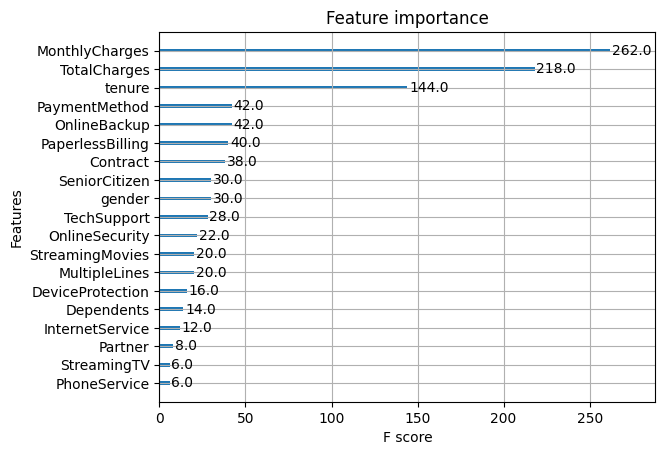

In [6054]:
xgb.plot_importance(clf)

### Dom attribut som verkligen dominerar är MonthlyCharges, TotalCharges och tenure.
### MonthlyCharges, detta kan bero på att höga avgifter gör att en kund avslutar sitt abonnemang.
### TotalCharges, detta kan bero på att om en kund har höga totala kostnader hos företaget gör att dom är mindre troliga att lämna.
### Tenure, lite samma som i fallet med TotalCharges så kan den ha stor vikt om det är lägre chans för avhopp ju längre en kund har varit kund hos företaget.

### För att undersöka detta så ska jag gå igenom samtliga och se om det stämmer baserat på avhopp.

In [6055]:
def get_column_values_by_churn(dataset, column, churn_value):
    values = dataset.loc[dataset['Churn'] == churn_value, column].values
    return values

In [6056]:
monthly_churn_yes_values = get_column_values_by_churn(my_encoded_test_df, 'MonthlyCharges', 1)
monthly_churn_no_values = get_column_values_by_churn(my_encoded_test_df, 'MonthlyCharges', 0)
total_churn_yes_values = get_column_values_by_churn(my_encoded_test_df, 'TotalCharges', 1)
total_churn_no_values = get_column_values_by_churn(my_encoded_test_df, 'TotalCharges', 0)
tenure_churn_yes_values = get_column_values_by_churn(my_encoded_test_df, 'tenure', 1)
tenure_churn_no_values = get_column_values_by_churn(my_encoded_test_df, 'tenure', 0)

In [6057]:
print(f'Genomsnittlig månadskostnad för dom som lämnat: {sum(monthly_churn_yes_values)/len(monthly_churn_yes_values)}')
print(f'Genomsnittlig månadskostnad för dom som stannat: {sum(monthly_churn_no_values)/len(monthly_churn_no_values)}')

Genomsnittlig månadskostnad för dom som lämnat: 74.36671018276758
Genomsnittlig månadskostnad för dom som stannat: 60.80740740740737


### Detta bevisar att ju högre kostnad desto högre är risken att kunden lämnar.

In [6058]:
print(f'Genomsnittlig totalkostnad för dom som lämnat: {sum(total_churn_yes_values)/len(total_churn_yes_values)}')
print(f'Genomsnittlig totalkostnad för dom som stannat: {sum(total_churn_no_values)/len(total_churn_no_values)}')

Genomsnittlig totalkostnad för dom som lämnat: 1517.6588772845962
Genomsnittlig totalkostnad för dom som stannat: 2452.960428849906


### Detta bevisar att ju mer en kund har i totala kostnader desto lägre chans är det att den lämnar.

In [6059]:
print(f'Genomsnittlig kundtid för dom som lämnat: {sum(tenure_churn_yes_values)/len(tenure_churn_yes_values)}')
print(f'Genomsnittlig kundtid för dom som stannat: {sum(tenure_churn_no_values)/len(tenure_churn_no_values)}')

Genomsnittlig kundtid för dom som lämnat: 17.642297650130548
Genomsnittlig kundtid för dom som stannat: 36.32846003898636


### Detta bevisar att ju längre kunden har varit kund hos företaget desto mindre chans är det att den lämnar. 

## ○ Rita ut en confusion matrix och analysera hur modellen gör prediktioner och vilka typer av fel den gör.

In [6060]:
lab = y_test.unique()
lab = sorted(lab)
cm = confusion_matrix(y_test, predictions, labels=lab)

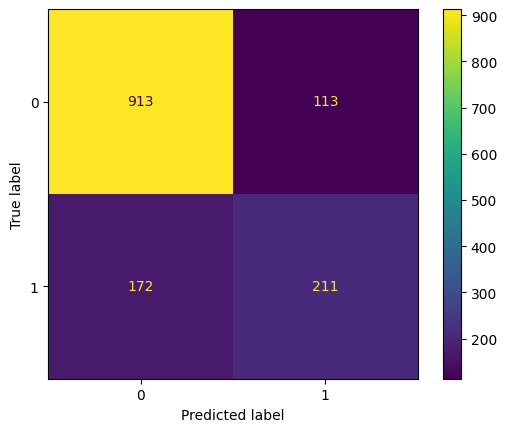

In [6061]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab)
disp.plot()
plt.show()

In [6062]:
test_df['Churn'].value_counts()

Churn
No     1026
Yes     383
Name: count, dtype: int64

### För att få en lite klarare bild av vad vi kollar på så skrev jag även raden ovanför på dom riktiga värdena. Som vi då ser i tabellen så är det högst procentuella fel när den ska predikta om en kund lämnar, och detta har högst troligen med att göra att när vi tränar modellen med så ojämnt fördelat targetdata som i en tidigare fråga så blir det att modellen väljer den som har majoritet. Och eftersom att beställaren är ute efter att kunna förutspå om en kund ska lämna så även fast scoren blir bra så kanske det inte är vad dom är ute efter. Jag hade ansett att ett lite sämre score men med flera rätt där det faktiskt betyder skulle vara en bättre modell, så beställaren kan vidta åtgärder. Och eftersom att vi i den tidigare frågan vet vilka attribut som spelar mest roll för kundens beslut så vet man vad man ska fokusera på och hur man ska öka kundlojaliteten.
### En stor del är ju priset på tjänsten och hur länge en kund har varit kund, och detta kanske man kan lägga fokus på att skapa någon form av kampanj att man får ett bättre pris under en period när man startar sitt konto eller se över kostnaden i det stora hela.
### Jag kommer försöka se om jag kan ändra en parameter som heter weight i modellen för att försöka få den att predicta mer som lämnat.

# Nedan så kommer jag försöka få fler rätta prediktioner på dom som lämnat.

### Först så vill jag utforska lite angående att vi har ett ojämt antal targets i datasetet, 74% som stannade och 26% som lämnade, så jag kommer titta närmare på att balansera upp det genom att ändra i weight så att modellen har en högre chans att välja den.

In [6063]:

target_dist = [74, 26]  # Procent för varje klass [stannade, lämnade]

# Beräkna vikter baserat på förhållandet mellan andelarna
weight_stayed = 1.0
weight_churned = target_dist[0] / target_dist[1]

# Skapa en lista med feature weights baserat på målklassen för varje exempel
feature = [weight_stayed if y == 0 else weight_churned for y in y_train]

m_x_train = xgb.DMatrix(data=x_train, label=y_train, weight=feature)
m_x_test = xgb.DMatrix(data=x_test)

In [6064]:
clf = xgb.train(
    params={
        'objective':'multi:softmax',
        'num_class':2,
    },
    dtrain = m_x_train
)

In [6065]:
predictions = clf.predict(m_x_test)

In [6066]:
accuracy_score(y_test,predictions)

0.7459190915542938

In [6067]:
lab = y_test.unique()
lab = sorted(lab)
cm = confusion_matrix(y_test, predictions, labels=lab)

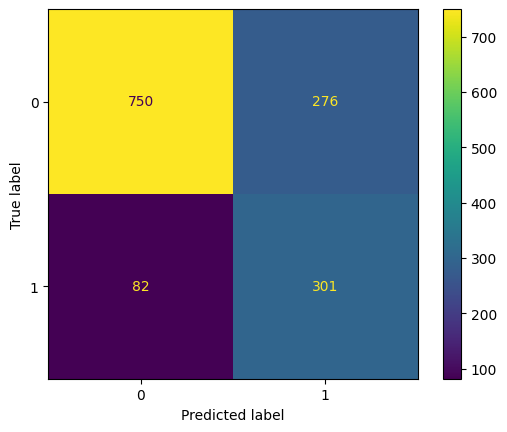

In [6068]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab)
disp.plot()
plt.show()

### Genom att sätta weights så kompenseras predictsen ut lite mer och den faktiskt kan sätta några som att dom har lämnat. Detta kanske är bättre i detta fallet då målet är att förutspå det och kanske rikta in sig på dom kunderna att söka sig till, då är det bättre att få fel än åt andra hållet.

## Nu kommer jag att testa en till metod man kan använda när det är ojämna targets i datasetet, SMOTE. Den kompenserar upp datasetet med datapunkter som är lika dom som redan finns för att göra så att det finns lika många datapunkter av båda targets.

In [6069]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='auto', random_state=42)
X, y = oversample.fit_resample(x_train, y_train)

In [6070]:
m_x_train = xgb.DMatrix(data=X, label=y)
m_x_test = xgb.DMatrix(data=x_test)

In [6071]:
clf = xgb.train(
    params={
        'objective':'multi:softmax',
        'num_class':2,
    },
    dtrain = m_x_train
)

In [6072]:
predictions = clf.predict(m_x_test)

In [6073]:
accuracy_score(y_test,predictions)

0.7537260468417317

In [6074]:
lab = y_test.unique()
lab = sorted(lab)
cm = confusion_matrix(y_test, predictions, labels=lab)

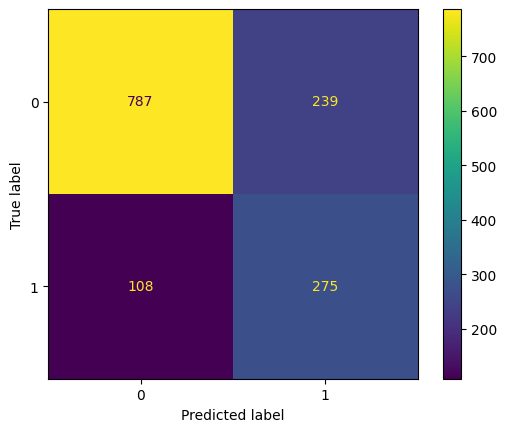

In [6075]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab)
disp.plot()
plt.show()

### Lite som att ändra weight så gör detta att den får mer rätt på dom som lämnat, men till en kostnad av felaktiga prediktioner på dom som stannat. 

# Nu kommer jag försöka ändra parametrar för att få ett bättre originalscore, detta oberoende av vilka fel den gör.

In [6076]:
X = my_encoded_train_df.drop(columns=['Churn'])
y = my_encoded_train_df['Churn']

### Först delar vi upp original träningsdatan i validering och träningsdataset, eftersom att vi vill få fram opartiska bästa parametrar för modellen.

In [6077]:
x_train, x_validation, y_train, y_validation = train_test_split(X,y, test_size=0.3, random_state=42)

In [6078]:
m_x_train = xgb.DMatrix(data=x_validation, label=y_validation)
m_x_test = xgb.DMatrix(data=x_test)

In [6079]:
objectives = ['reg:squarederror', 'reg:logistic','binary:logistic','count:poisson','rank:pairwise']
best_score = 0
# 'reg:logistic', 'binary:logistic', 'count:poisson', 'multi:softmax', 'rank:pairwise', 'reg:gamma'
for o in objectives:
    clf = xgb.train(
        params={
            'booster':'gblinear',
            'objective':o,
        },
        dtrain = m_x_train
    )
    predictions = clf.predict(m_x_test)
    binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]
    score = accuracy_score(y_test,binary_predictions)
    if score > best_score:
        best_score = score
        print(f'Objective: {o}, Score: {score}')
# if score > best_score:
#     best_score = score
#     print(f'rate_drop: {rd}, skip_drop: {sd}, eta: {e}, max_depth: {md}, Score: {score}')

Objective: reg:squarederror, Score: 0.7835344215755855
Objective: binary:logistic, Score: 0.7877927608232789


### Efter att ha testat dart som booster så märker jag att rate_drop och skip_drop verkar inte göra någon skillnad jämfört med den vanliga gbtree så jag väljer att inte fokusera alls på den.
### Jag märker även att ha linear som booster inte kommer upp i samma resultat som att ha träd, att träd är bättre verkar vara ett ganska vanligt förekommande men jag ville testa vad det blev för skillnad i just detta fall med mitt dataset.

In [6088]:
objectives = ['reg:squarederror', 'reg:logistic','binary:logistic','count:poisson','rank:pairwise', 'multi:softmax']
eta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
max_depth = [1,2,3,4,5,6,7,8,9,10]
# max_delta_step = [0,1,2,3,4,5,6,7,8,9]
tree_method = ['auto','approx','hist']
best_score = 0

for o in objectives:
    for tm in tree_method:
        for md in max_depth:
            for e in eta:
                if o == 'multi:softmax':
                    clf = xgb.train(
                        params={
                            # 'objective':'multi:softmax',
                            'num_class':2,
                            'objective':o,
                            'eta':e,
                            'max_depth':md,
                            # 'max_delta_step':mds
                            'tree_method':tm
                        },
                        dtrain = m_x_train
                    )
                else:
                    clf = xgb.train(
                        params={
                            'objective':o,
                            'eta':e,
                            'max_depth':md,
                            'tree_method':tm
                        },
                        dtrain = m_x_train
                    )
                predictions = clf.predict(m_x_test)
                binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]
                score = accuracy_score(y_test,binary_predictions)
                if score > best_score:
                    best_score = score
                    print(f'ETA: {e}, max depth: {md}, objective: {o} tree_method: {tm} Score: {score}')

ETA: 0.1, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.7281760113555713
ETA: 0.2, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.7679205110007097
ETA: 0.5, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.7757274662881476
ETA: 0.6, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.7913413768630234
ETA: 0.8, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.794889992902768
ETA: 0.9, max depth: 1, objective: reg:squarederror tree_method: auto Score: 0.7963094393186657
ETA: 0.6, max depth: 2, objective: reg:squarederror tree_method: auto Score: 0.801277501774308
ETA: 0.4, max depth: 4, objective: reg:squarederror tree_method: auto Score: 0.8069552874378992
ETA: 0.8, max depth: 2, objective: reg:logistic tree_method: approx Score: 0.808374733853797


### max_delta_step verkar inte göra så stor skillnad i resultat så jag kommenterar ut den.
### Intressant nog så dyker det upp lite olika alternativ när jag kör denna, men jag tog en av dom som dök upp mest.

In [6089]:
m_x_train = xgb.DMatrix(data=x_train, label=y_train)
m_x_test = xgb.DMatrix(data=x_test)

In [6090]:
clf = xgb.train(
            params={
                'objective':'reg:squarederror',
                # 'num_class':2,
                'eta':0.4,
                'max_depth':4,
                # 'max_delta_step':0,
                'tree_method':'auto',
            },
            dtrain = m_x_train
        )

In [6091]:
predictions = clf.predict(m_x_test)

In [6092]:
binary_predictions = [1 if pred >= 0.5 else 0 for pred in predictions]

In [6093]:
accuracy_score(y_test,binary_predictions)

0.8069552874378992

In [6094]:
lab = y_test.unique()
lab = sorted(lab)
cm = confusion_matrix(y_test, binary_predictions, labels=lab)

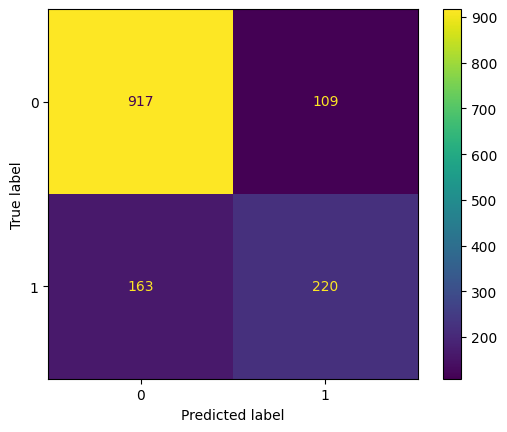

In [6095]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab)
disp.plot()
plt.show()

### Något bättre resultat än när vi bara körde softmax från första början, och även ett fåtal till som är klassade att lämna, men jag skulle fortfarande säga att man vill försöka balansera scoren med hur många rätt den gör på dom som är påväg att lämna istället för att bara få bra score.